# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [30]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [242]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load Analysis Input

In [32]:
path,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
pathfields = "/Output/Raw/Sp01/raw_sp01_{:08d}.h5"

In [33]:
print(path,vmax,dv,numframe,dx,xlim,ylim,zlim)

M06_th45/ 25.0 0.5 2000 0.5 [39.0, 43.0] [0.0, 3.0] [0.0, 3.0]


### Load data

In [224]:
#load fields
dfields = dh5.field_loader(path=path_fields,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

In [38]:
dfields.keys()

dict_keys(['bx', 'bx_xx', 'bx_yy', 'bx_zz', 'by', 'by_xx', 'by_yy', 'by_zz', 'bz', 'bz_xx', 'bz_yy', 'bz_zz', 'ex', 'ex_xx', 'ex_yy', 'ex_zz', 'ey', 'ey_xx', 'ey_yy', 'ey_zz', 'ez', 'ez_xx', 'ez_yy', 'ez_zz', 'Vframe_relative_to_sim'])

In [39]:
dfields['Vframe_relative_to_sim']

-3.7638815441565305

In [13]:
import time
start = time.time()
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  72.80520129203796


In [14]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

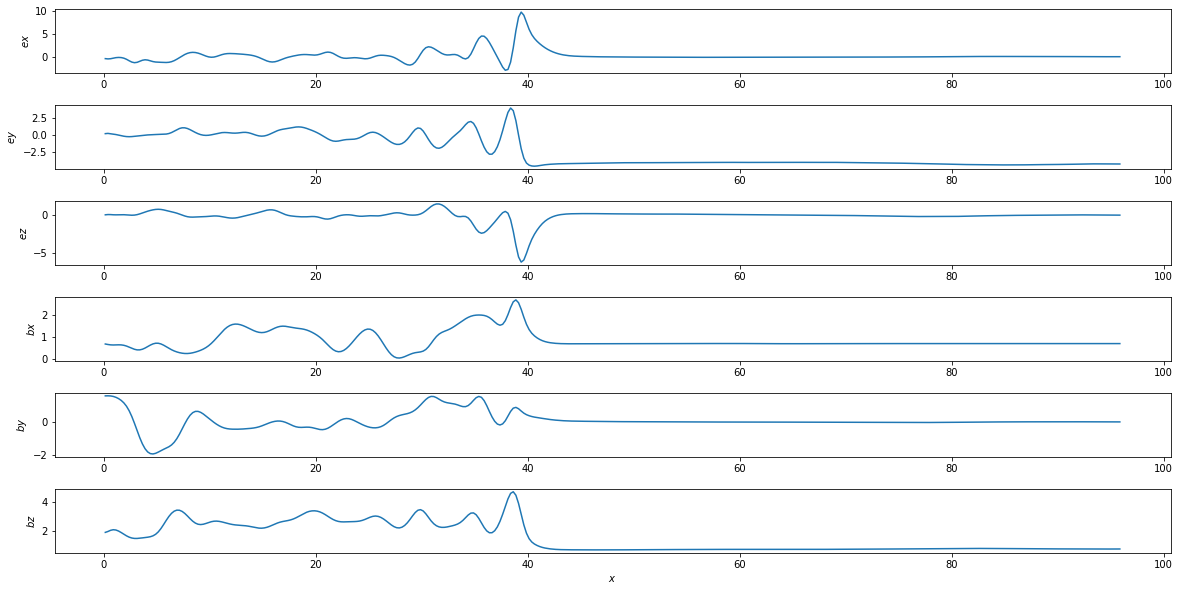

In [15]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

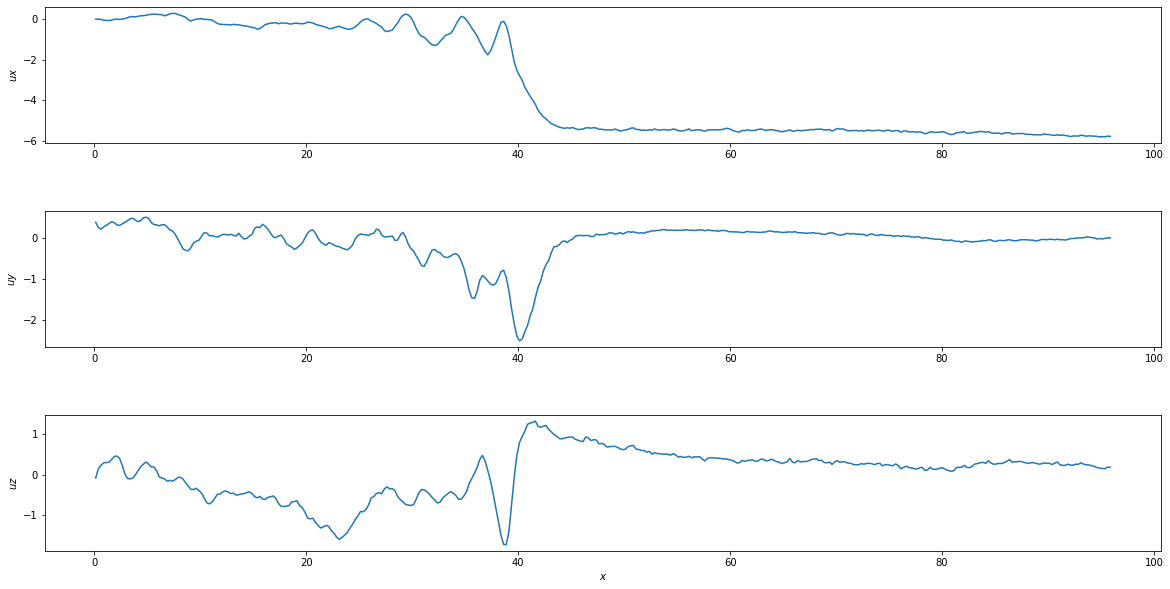

In [16]:
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

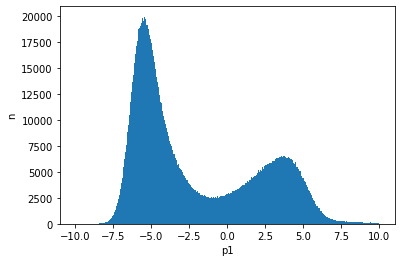

<Figure size 432x288 with 0 Axes>

In [17]:
pltdebug.plot_1d_dist(dparticles, 'p1', 10., xlim[0], xlim[1], ylim[0], ylim[1])

### Compute Shock Vel and Lorentz transform fields

In [225]:
#pick some point in the middle of the simulation and plot it as a function of time
all_dfields = dh5.all_dfield_loader(path=path_fields, verbose=False)


In [226]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


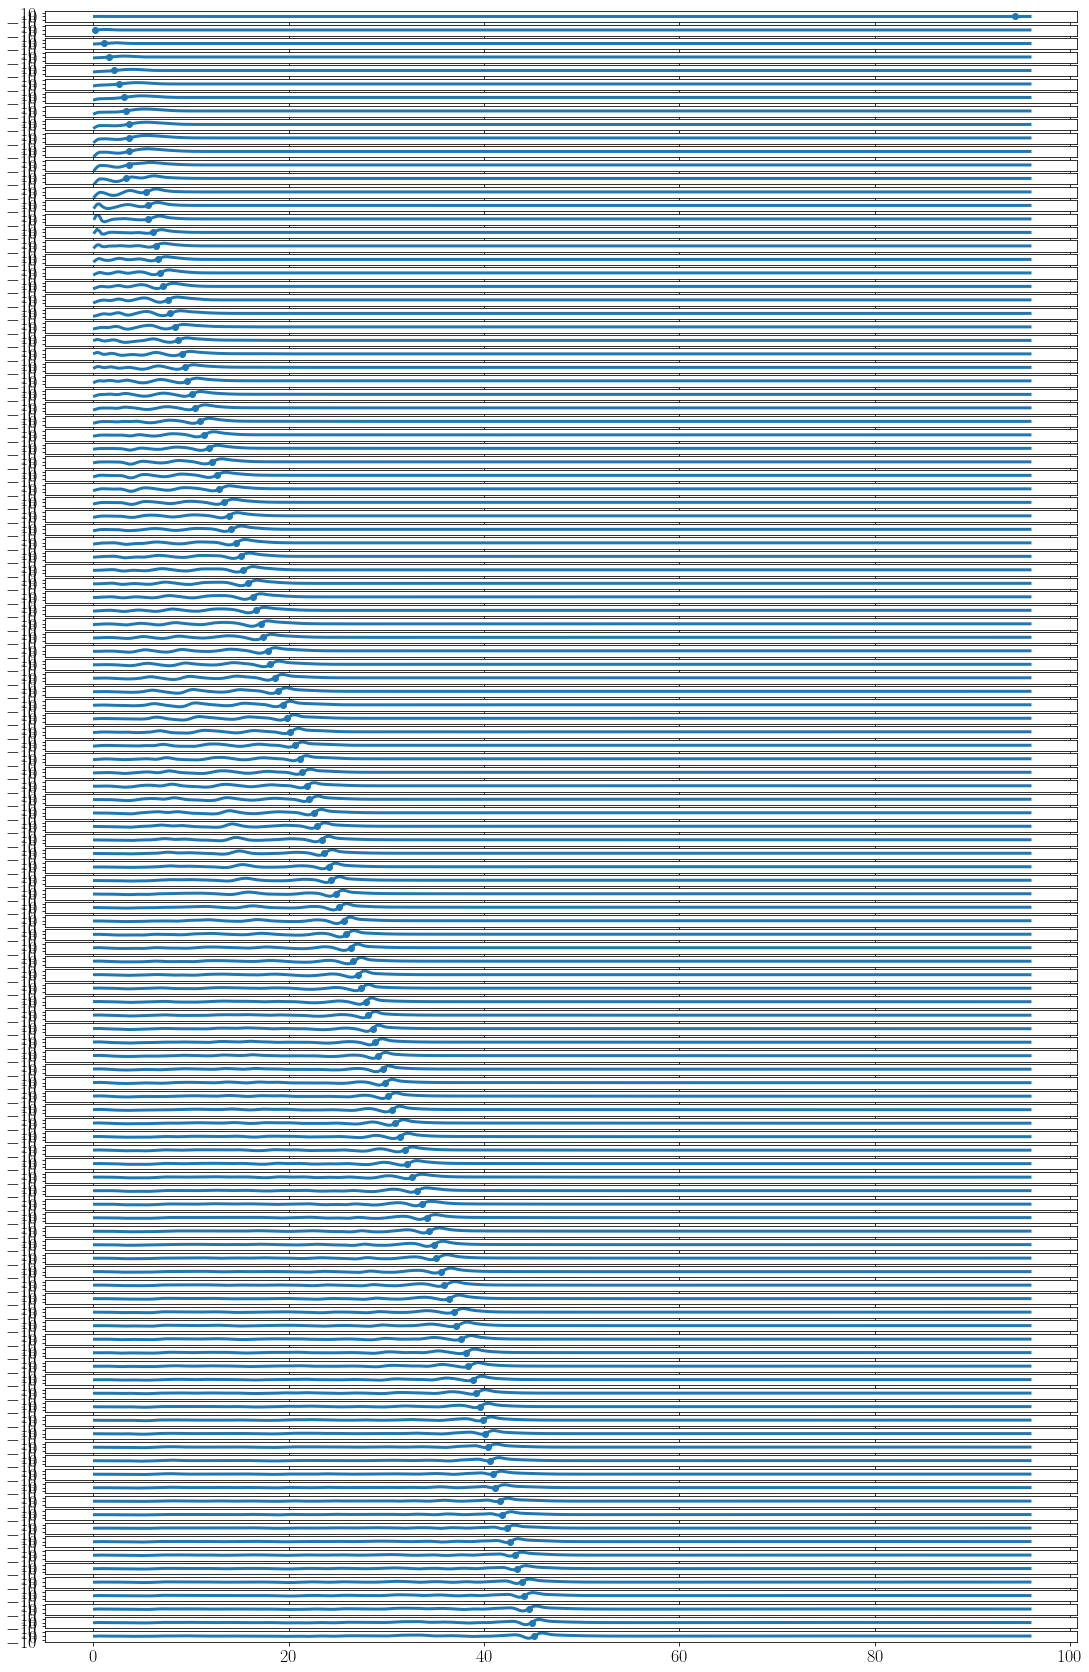

In [227]:
plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [228]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

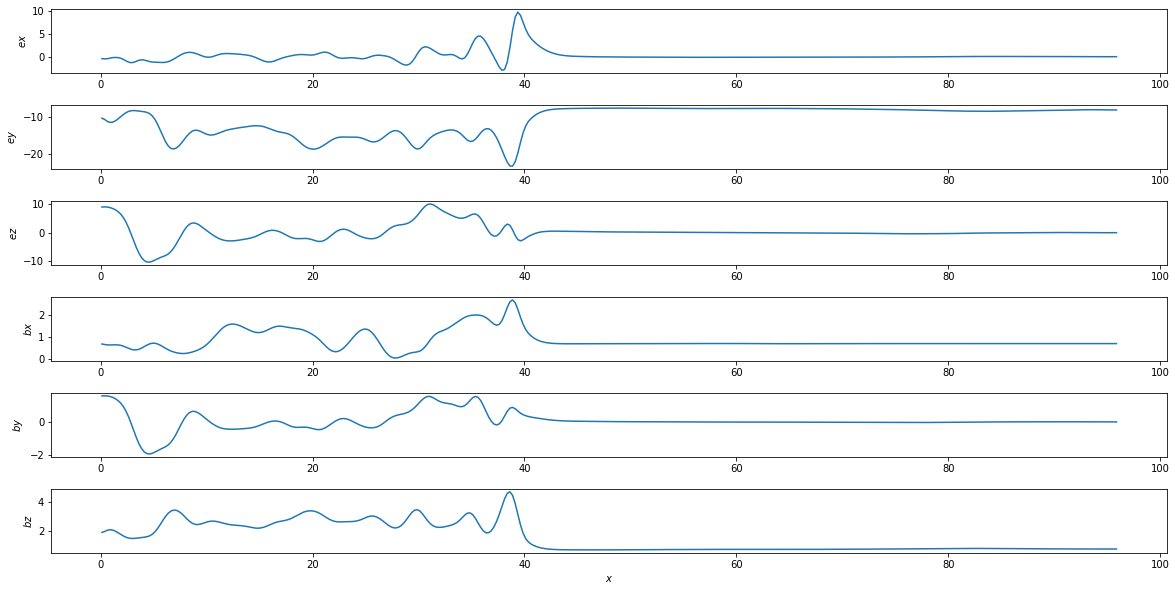

In [48]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

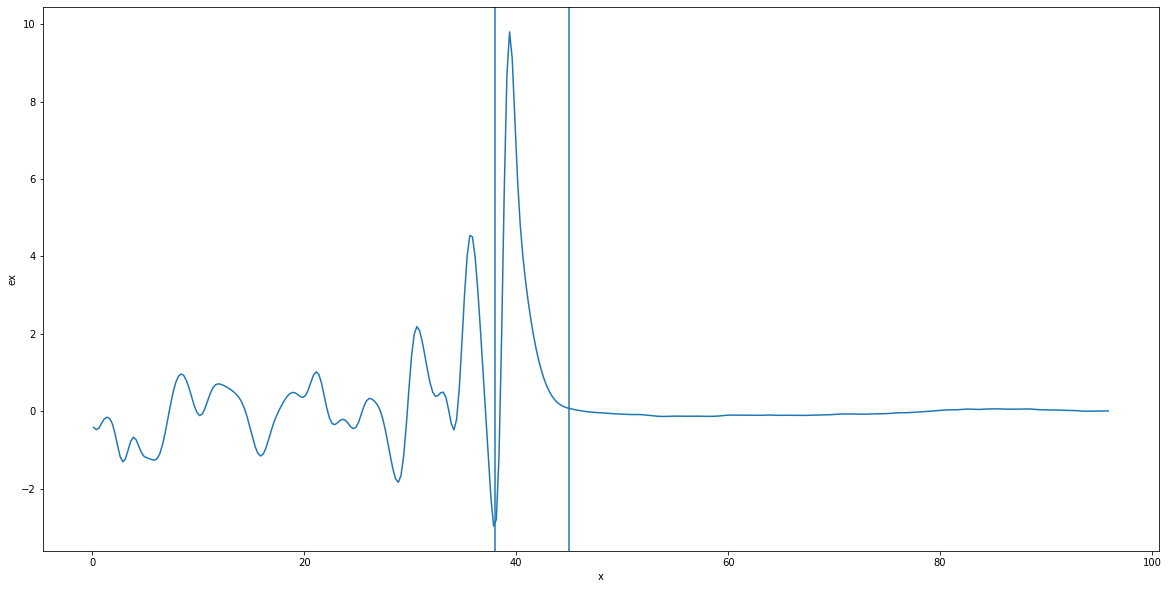

In [49]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 38.#lower bound for metadata = 1 (di)
endval = 45. #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [50]:
metadata = md.build_metadata(dfields, startval, endval)

In [51]:
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Test super plot

In [55]:
x1 = xlim[0]
x2 = xlim[1]
y1 = ylim[0]
y2 = ylim[1] 
z1 = zlim[0] 
z2 = zlim[1]

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [56]:
totalPtcl

4421531

In [57]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

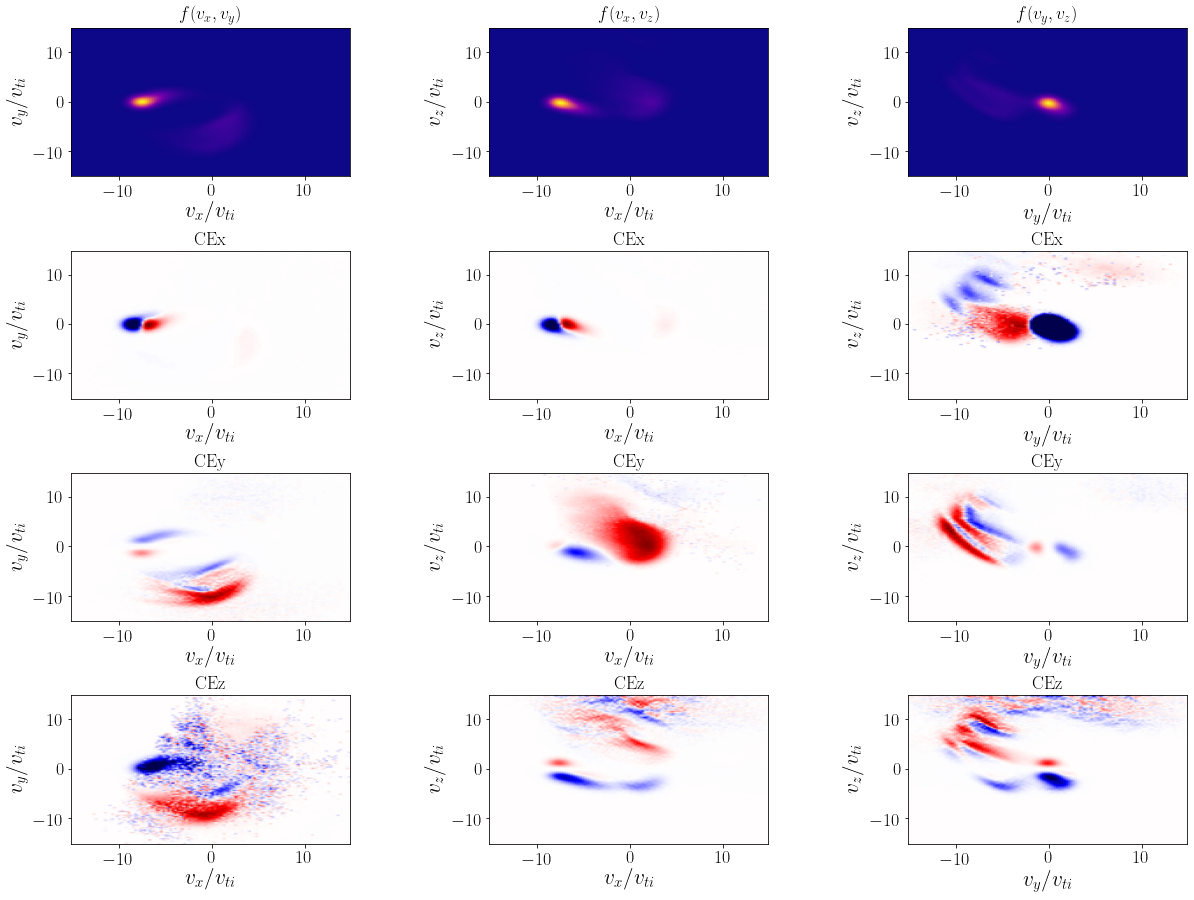

In [58]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [60]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = fpc.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock,xlim=xlim,ylim=ylim,zlim=zlim)

39.0 39.5 0.0 3.0 0.0 3.0
1044917
39.5 40.0 0.0 3.0 0.0 3.0
758232
40.0 40.5 0.0 3.0 0.0 3.0
599543
40.5 41.0 0.0 3.0 0.0 3.0
504628
41.0 41.5 0.0 3.0 0.0 3.0
435940
41.5 42.0 0.0 3.0 0.0 3.0
388730
42.0 42.5 0.0 3.0 0.0 3.0
354848
42.5 43.0 0.0 3.0 0.0 3.0
334662


### Make superplot gif

In [61]:
pltvv.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

Making plot 0 of 8
Making plot 1 of 8
Making plot 2 of 8
Making plot 3 of 8
Making plot 4 of 8
Making plot 5 of 8
Making plot 6 of 8
Making plot 7 of 8


In [62]:
rsltmng.make_gif_from_folder('superplotGraphs','superplottest.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png', '0000

### Convert to previous '2v FPC' formatting

In [106]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_out = []
CEy_out = []
for i in range(0,len(CEx)):
    CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
    CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
    CEx_out.append(CEx_xy)
    CEy_out.append(CEy_xy)
    
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
vx_out = vx_xy
vy_out = vy_xy
x_out = x

### Compute energization from correlations

In [64]:
#TODO: project onto 2d plane and handle different projections net energization
enerCEx_out = anl.compute_energization_over_x(CEx_out,dv)
enerCEy_out = anl.compute_energization_over_x(CEy_out,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [69]:
inputdict = dnc.parse_input_file(path)

In [125]:
params = dnc.build_params(inputdict,numframe)

In [126]:
inputdict

{'': [''],
 'node_conf_node_number(1:3)': [14.0, 4.0, 4.0],
 'time_dt': [0.01],
 'time_niter': [1000.0],
 'time_t0': [0.0],
 'time_stiter': [0.0],
 'time_c': [125.0],
 'grid_space_ncells(1:3)': [192.0, 48.0, 48.0],
 'grid_space_boxsize(1:3)': [48.0, 12.0, 12.0],
 'grid_space_bdtype': ['reflect', 'open', 'per', 'per', 'per', 'per'],
 'grid_space_Te': [1.0],
 'grid_space_gamma': [1.66667],
 'global_output_dodump': ['.true.'],
 'global_output_ndump': [100.0],
 'global_output_B0': ['3.05191d-7'],
 'global_output_n0': ['1.d6'],
 'global_output_units': ['NORM'],
 'global_output_do_restart': ['.false.'],
 'global_output_save_restart': ['.true.'],
 'global_output_restart_step': [1000.0],
 'global_output_restart_time': [85000.0],
 'global_output_restart_time_step': [100.0],
 'ext_emf_Bx': [0.0],
 'ext_emf_By': [0.0],
 'ext_emf_Bz': [1.0],
 'ext_emf_Ex': [0.0],
 'ext_emf_Ey': [0.0],
 'ext_emf_Ez': [0.0],
 'ext_emf_n_constants': [0.0],
 'ext_emf_Jext(1:3)': [0.0, 0.0, 0.0],
 'ext_emf_NoiseLevel(1

In [127]:
params

{'MachAlfven': -3.0,
 'MachAlfvenNote': 'TODO: compute mach alfven for this run',
 'thetaBn': 90.0,
 'thetaBndesc': 'units of degrees',
 'betaelec': 1.0,
 'betaion': 0.5000000000190247,
 'simtime': 20.0,
 'simtimedesc': 'units of inverse Omega_{c,i,0}',
 'qi': 1.0,
 'qidesc': 'charge to mass ratio',
 'di': 0.0,
 'didesc': 'TODO: compute ion inertial length',
 'vti': 0.7071067812}

In [206]:
flnm = 'dHybridRSDAv1test2.nc'
try:
    dnc.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = [], params = params, filename = flnm)
except:
    os.system('rm '+flnm)
    dnc.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = [], params = params, filename = flnm)

Saving data into netcdf4 file


### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [207]:
CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load_netcdf4(flnm)

### Perform sanity checks
#### E cross B gif

In [134]:
dfields['bz_zz']

array([ 0.125,  0.375,  0.625,  0.875,  1.125,  1.375,  1.625,  1.875,
        2.125,  2.375,  2.625,  2.875,  3.125,  3.375,  3.625,  3.875,
        4.125,  4.375,  4.625,  4.875,  5.125,  5.375,  5.625,  5.875,
        6.125,  6.375,  6.625,  6.875,  7.125,  7.375,  7.625,  7.875,
        8.125,  8.375,  8.625,  8.875,  9.125,  9.375,  9.625,  9.875,
       10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875])

In [208]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEx_in, 'ex', x_out, dx, dfields, 'CExExB', 'CExExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

Making plot 0 of 8
Making plot 1 of 8
Making plot 2 of 8
Making plot 3 of 8
Making plot 4 of 8
Making plot 5 of 8
Making plot 6 of 8
Making plot 7 of 8


In [209]:
rsltmng.make_gif_from_folder('CExExB', 'CExExB.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png']


<img src="CExExB.gif" width="750" align="center">

In [145]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_in, 'ex', x_out, dx, dfields, 'CEyExB', 'CEyExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

Making plot 0 of 8
Making plot 1 of 8
Making plot 2 of 8
Making plot 3 of 8
Making plot 4 of 8
Making plot 5 of 8
Making plot 6 of 8
Making plot 7 of 8


In [147]:
rsltmng.make_gif_from_folder('CEyExB', 'CEyExB.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png']


<img src="CEyExB.gif" width="750" align="center">

##  Plot fields as a function of time

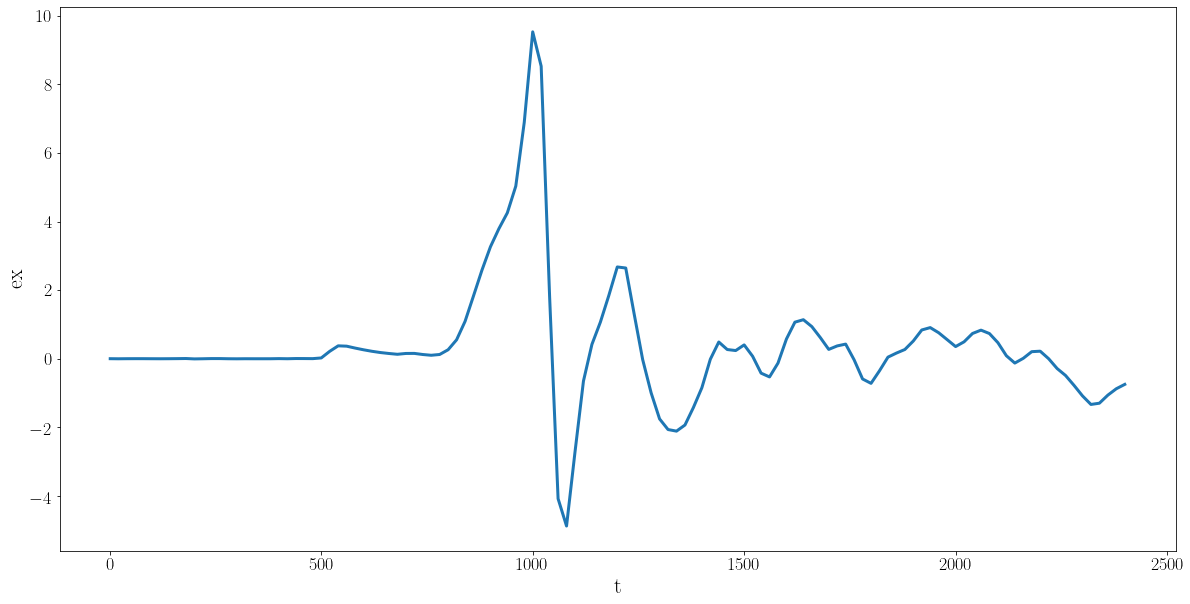

In [149]:
#Plots Ex(x=xxpltpoint,y=0,z=0;t)
xxpltpoint = 20.0 #di
xxindex = ao.find_nearest(dfields['ex_xx'], xxpltpoint)
plt1d.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [150]:
anl.get_abs_max_velocity(dparticles)

(24.843699, 23.83569, 27.088228)

### Test making field pmesh

<Figure size 468x432 with 0 Axes>

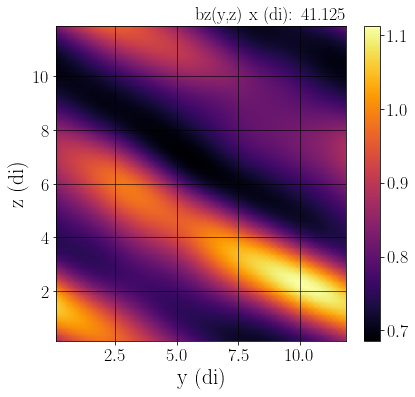

In [152]:
xxindex = 164
plt2d.make_field_pmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

<Figure size 468x432 with 0 Axes>

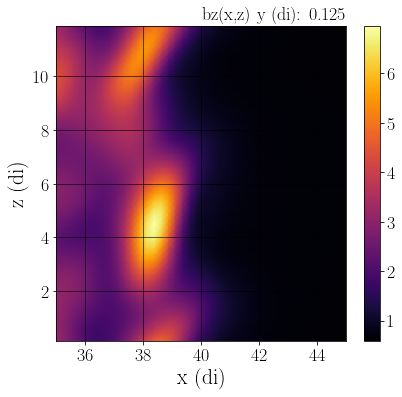

In [154]:
plt2d.make_field_pmesh(dfields,'bz','xz',takeaxisaverage=False,yyindex = 0,xlimmin=35,xlimmax=45)

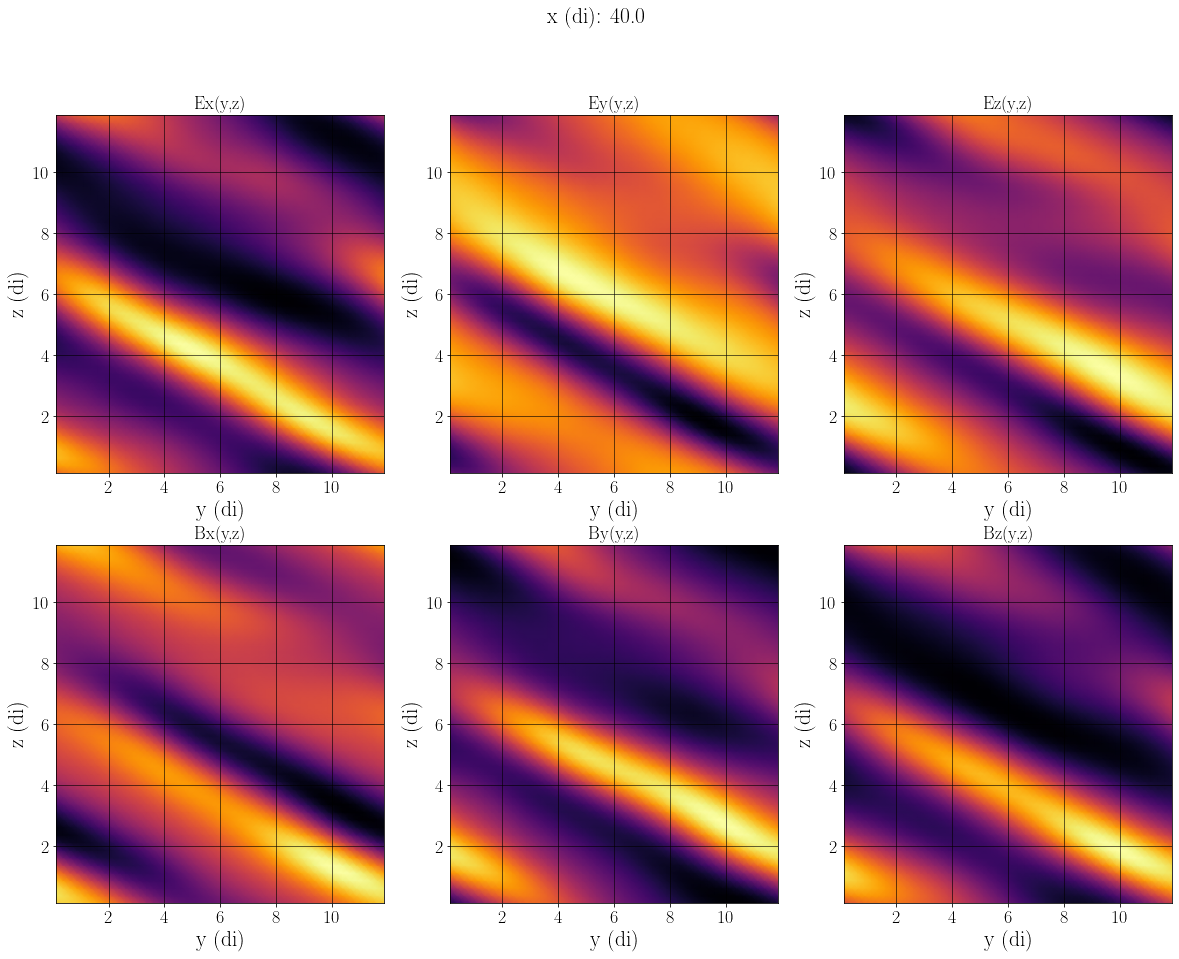

In [197]:
xx = 40.0
xxindex = ao.find_nearest(dfields['ex_xx'], xx)
plt2d.compare_pmesh_fields_yz(dfields, flnm = '', ttl ='x (di): ' + str(dfields['ex_xx'][xxindex]), takeaxisaverage=False, xxindex=xxindex)

In [204]:
plt2d.compare_pmesh_fields_yz_sweep(dfields,'pmeshsweep')

Making plot 0 of 384
Making plot 1 of 384
Making plot 2 of 384
Making plot 3 of 384
Making plot 4 of 384
Making plot 5 of 384
Making plot 6 of 384
Making plot 7 of 384
Making plot 8 of 384
Making plot 9 of 384
Making plot 10 of 384
Making plot 11 of 384
Making plot 12 of 384
Making plot 13 of 384
Making plot 14 of 384
Making plot 15 of 384
Making plot 16 of 384
Making plot 17 of 384
Making plot 18 of 384
Making plot 19 of 384
Making plot 20 of 384
Making plot 21 of 384
Making plot 22 of 384
Making plot 23 of 384
Making plot 24 of 384
Making plot 25 of 384
Making plot 26 of 384
Making plot 27 of 384
Making plot 28 of 384
Making plot 29 of 384
Making plot 30 of 384
Making plot 31 of 384
Making plot 32 of 384
Making plot 33 of 384
Making plot 34 of 384
Making plot 35 of 384
Making plot 36 of 384
Making plot 37 of 384
Making plot 38 of 384
Making plot 39 of 384
Making plot 40 of 384
Making plot 41 of 384
Making plot 42 of 384
Making plot 43 of 384
Making plot 44 of 384
Making plot 45 of 38

Making plot 361 of 384
Making plot 362 of 384
Making plot 363 of 384
Making plot 364 of 384
Making plot 365 of 384
Making plot 366 of 384
Making plot 367 of 384
Making plot 368 of 384
Making plot 369 of 384
Making plot 370 of 384
Making plot 371 of 384
Making plot 372 of 384
Making plot 373 of 384
Making plot 374 of 384
Making plot 375 of 384
Making plot 376 of 384
Making plot 377 of 384
Making plot 378 of 384
Making plot 379 of 384
Making plot 380 of 384
Making plot 381 of 384
Making plot 382 of 384
Making plot 383 of 384


In [205]:
rsltmng.make_gif_from_folder('pmeshsweep', 'pmeshsweep.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png', '0000

### Estimate Ripple size

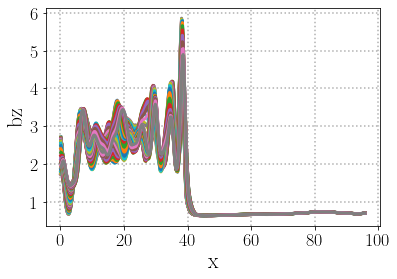

In [158]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)

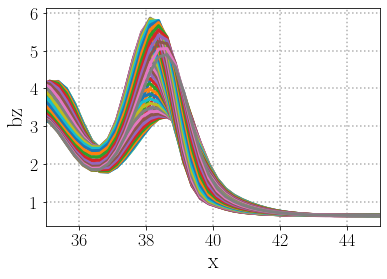

In [159]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

### Test 2d fourier (WIP)

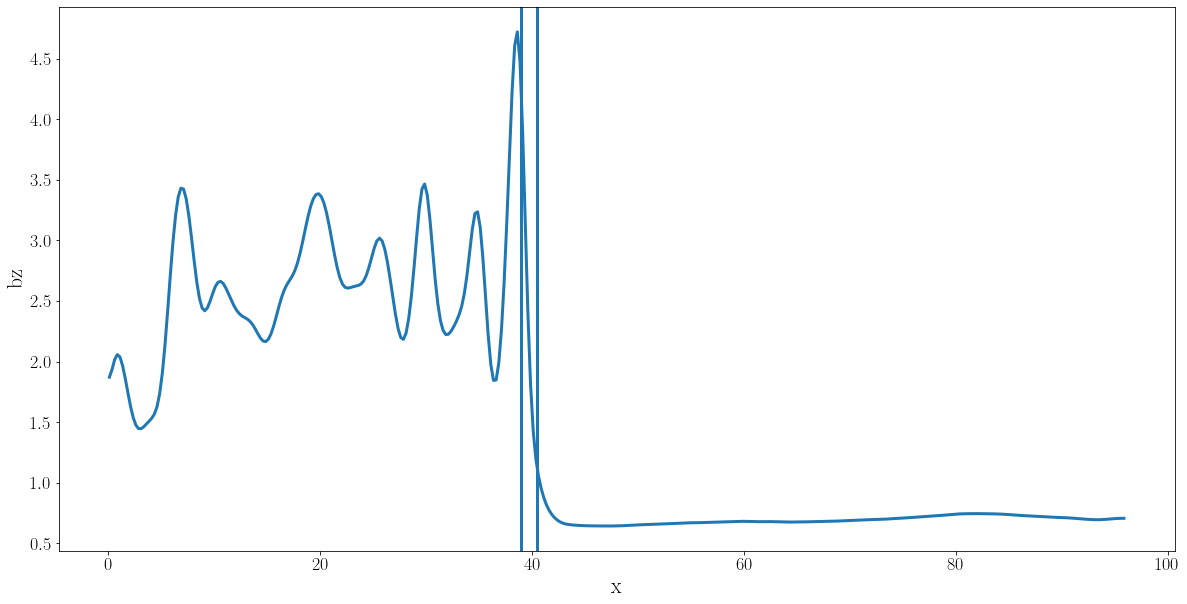

In [247]:
startval = 39.
endval = 40.5
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [ ]:
k0, k1, fieldpmesh, xplot, yplot = pltfr.plot_fft_norm(dfields,'bz','yz',plotlog = False,takeaxisaverage=False,xxindex=164)

### Test Energization vs J dot E (WIP)

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

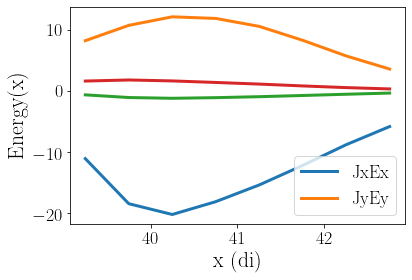

In [243]:
dflowtransform = ft.transform_flow(dflow,vshock)
pltdebug.check_JiEi_vs_CEi(dfields,dflowtransform,dparticles,x_in,enerCEx_in,enerCEy_in,dx,xlim=xlim,ylim=ylim,zlim=zlim)

In [229]:
dflowtransform['Vframe_relative_to_sim']

-1.8819407720782653

In [230]:
vshock

1.8819407720782653

In [231]:
dfields['Vframe_relative_to_sim']

-1.8819407720782653